In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time

from scipy.optimize import least_squares as ls
from rbergomi import rBergomi

In [2]:
def price_call(S, K, N, r, q, T):
    try:
        N = len(K)
        p = np.zeros(N)
        for i in range(N):
            p[i] = np.mean(np.maximum(S[:,-1]-K[i],0)*np.exp(-(r-q)*T))
        return p
    except:
        return np.mean(np.maximum(S[:,-1]-K,0)*np.exp(-(r-q)*T))

In [3]:
S0 = 4017.8
t0 = "23 Jan 2023"

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

r = 0.0291
q = 0.0154
K = moneyness*S0/100

In [4]:
np.random.seed(0)
H = 0.1; alpha = H - 0.5;
N = 25000; T = maturities[5]; n = 10000;
rB = rBergomi(n, N, T, alpha)

dW1 = rB.dW1(); dW2 = rB.dW2();

Ya = rB.Y(dW1)
dZ = rB.dZ(dW1, dW2, rho = -0.9)

V = rB.V(Ya, xi = 0.049, eta = 2.6)

S = rB.S(V, dZ, r, q, S0)

<IPython.core.display.Javascript object>


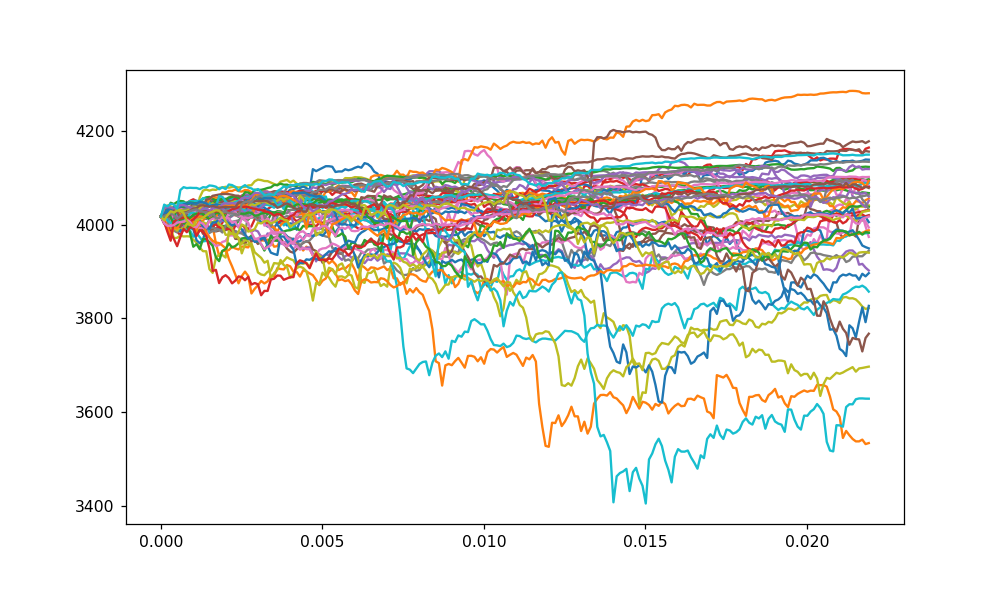

In [5]:
%matplotlib notebook

for i in range(50):
    plt.plot(rB.t[0],S[i])

In [30]:
def h(x):
    
    np.random.seed(0)
    
    H, eta, rho, xi = x
    N = 25000; T = maturities[5]; n = 5000;
    r = 0.0291; q = 0.0154;
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    dW1 = rB.dW1(); dW2 = rB.dW2();
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    S = rB.S(V, dZ, r, q, S0)
    
    P = price_call(S, K, N, r, q, T)
    rB_vol = bs.BSImpliedVol(S0, K, T, r, q, P, Option_type = 1, toll = 1e-10)

    return rB_vol

def f(x):
    return h(x) - vol

In [31]:
start_time = time.time()

vol = IV[5]
input = np.array([0.1, 1.9, -0.9, 0.45]) # Parameter array [H,eta,rho,xi]
bnds = ([.0001, 1, -0.999, .01],[.2, 7, -.8, .5])

result = ls(f, input, bounds = bnds, max_nfev = 10, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
rB_vol = result.x

print(f'Time to run: {time.time() - start_time: .0f} s')

Time to run:  34 s


<IPython.core.display.Javascript object>


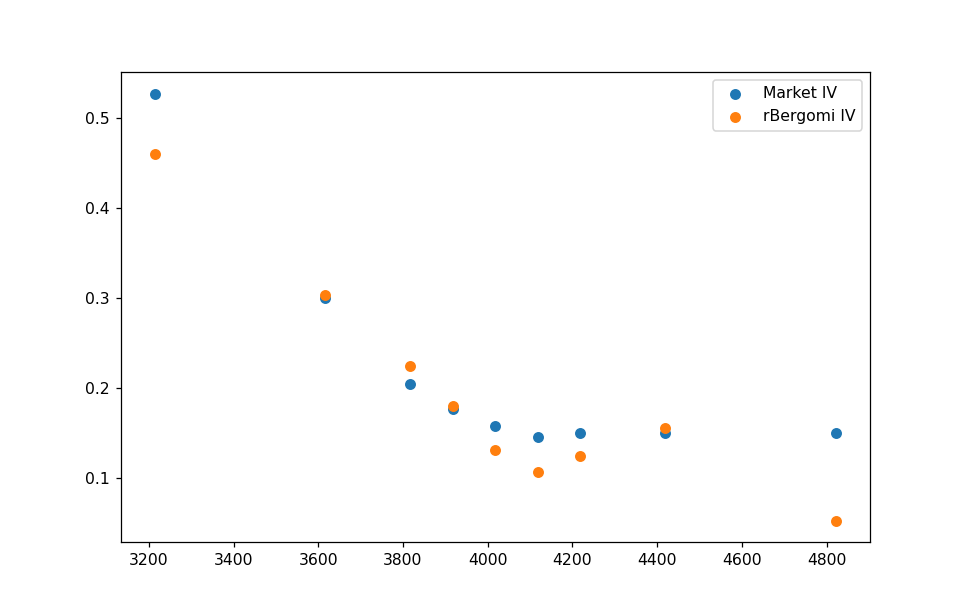

In [33]:
%matplotlib notebook

plt.scatter(K, vol)
plt.scatter(K, h(rB_vol))
plt.legend(["Market IV","rBergomi IV"])

In [34]:
start_time = time.time()

nr = len(maturities); nc = len(K);
rB_vol = np.zeros([nr,nc]); rB_param = np.zeros([nr,4])

for i in range(6):
    vol = IV[i]
    input = np.array([0.1, 1.9, -0.9, 0.45]) # Parameter array [H,eta,rho,xi]
    bnds = ([.0001, 1, -0.999, .01],[.2, 7, -.8, .5])
    T = maturities[i]; N = 25000; n = 5000;
    r = 0.0291; q = 0.0154;
    
    def h(x):
    
        np.random.seed(0)

        H, eta, rho, xi = x
        alpha = H - 0.5

        rB = rBergomi(n, N, T, alpha)
        dW1 = rB.dW1(); dW2 = rB.dW2();
        Ya = rB.Y(dW1)
        dZ = rB.dZ(dW1, dW2, rho)
        V = rB.V(Ya, xi, eta)
        S = rB.S(V, dZ, r, q, S0)

        P = price_call(S, K, N, r, q, T)
        rB_v = bs.BSImpliedVol(S0, K, T, r, q, P, Option_type = 1, toll = 1e-10)

        return rB_v

    def f(x):
        return h(x) - vol

    result = ls(f, input, bounds = bnds, max_nfev = 10, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
    rB_vol[i,:] = h(result.x)
    rB_param[i,:] = result.x

print(f'Time to run: {time.time() - start_time: .0f} s')

Time to run:  145 s


<IPython.core.display.Javascript object>


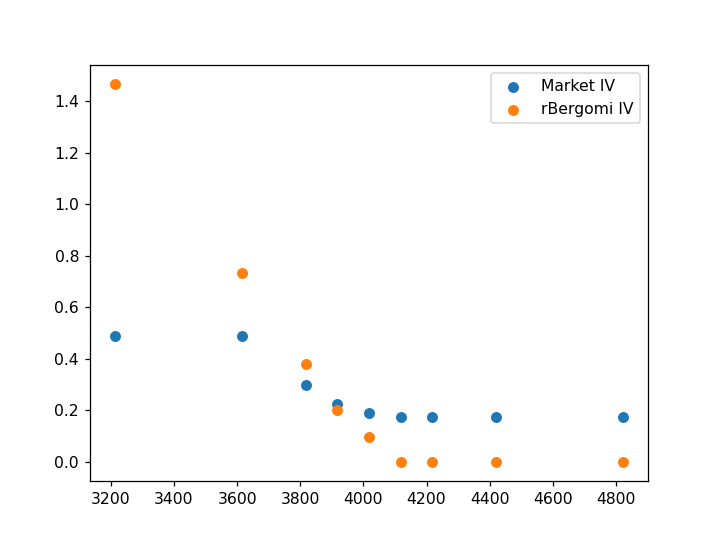

<IPython.core.display.Javascript object>


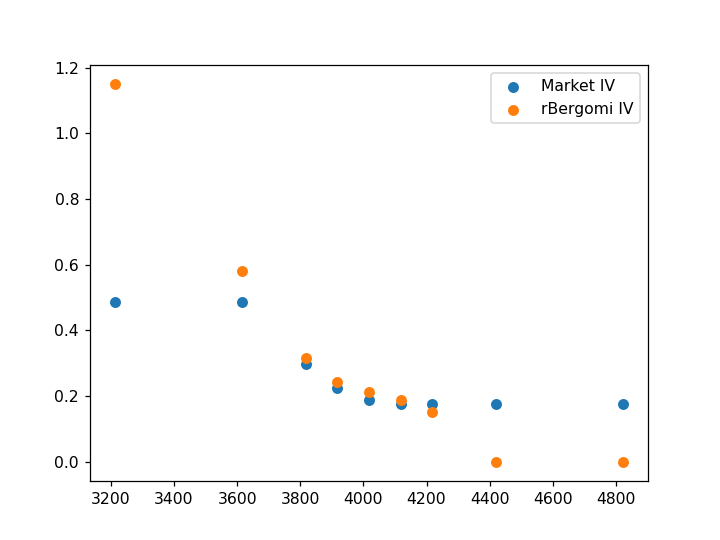

<IPython.core.display.Javascript object>


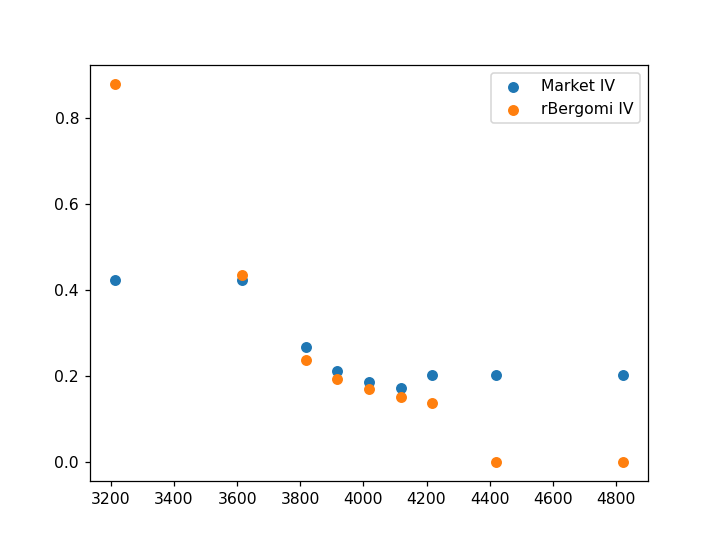

<IPython.core.display.Javascript object>


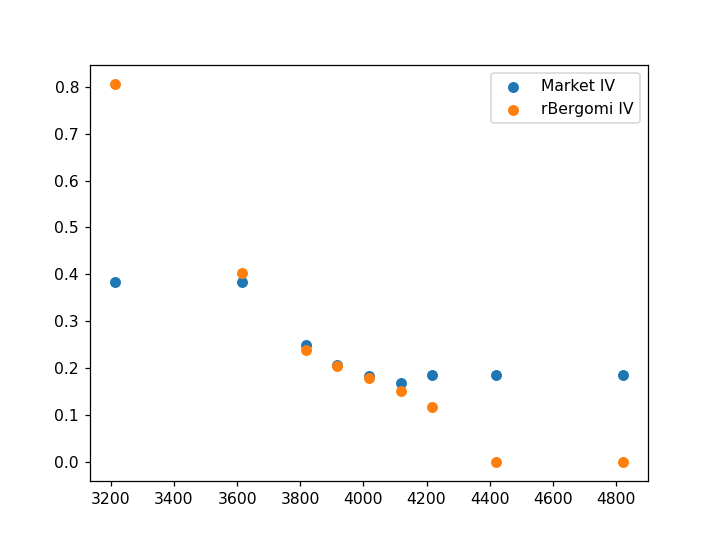

<IPython.core.display.Javascript object>


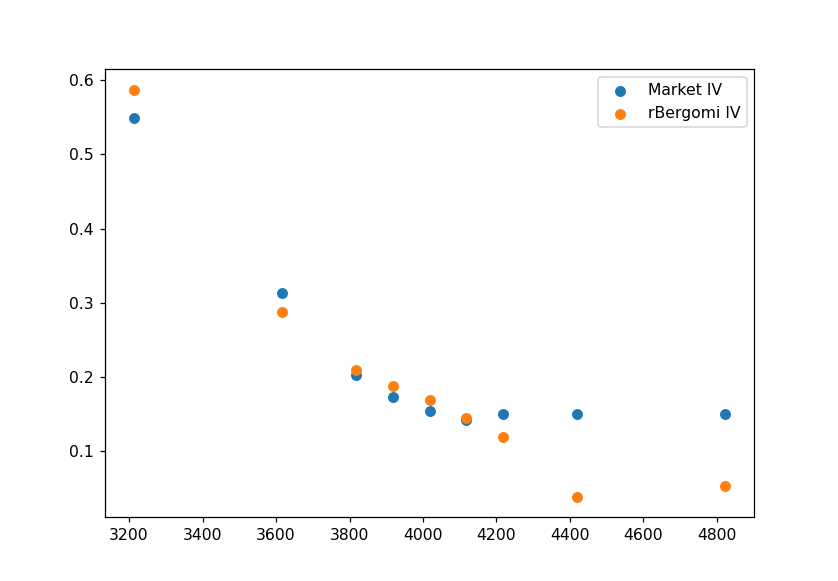

In [35]:
%matplotlib notebook

for i in range(5):
    plt.figure(i)
    plt.scatter(K, IV[i])
    plt.scatter(K, rB_vol[i,:])
    plt.legend(["Market IV","rBergomi IV"])